2023-11-19 00:16:48.527 Python[17640:704033] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


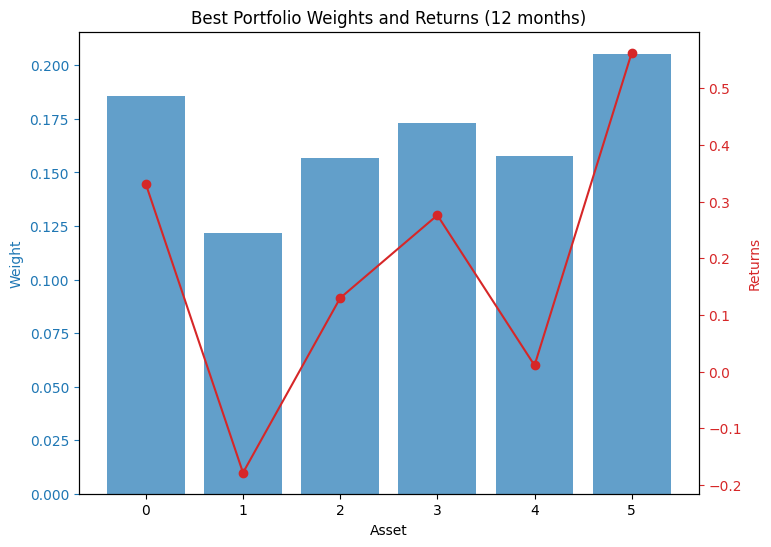

In [1]:
import numpy as np
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import (
     FigureCanvasTkAgg)
import tkinter as tk
from tkinter import messagebox

# File paths
files = ['/Users/divyanshukumar/Downloads/m&m.csv', '/Users/divyanshukumar/Downloads/itc.csv', '/Users/divyanshukumar/Downloads/l&t.csv', '/Users/divyanshukumar/Downloads/hdfc.csv', '/Users/divyanshukumar/Downloads/sunpha.csv', '/Users/divyanshukumar/Downloads/tcs.csv']
dfs = []

for file in files:
    temp = pd.read_csv(file)
    temp.columns = ['Date', file.replace('.csv', '')]
    dfs.append(temp)

stocks = reduce(lambda left, right: pd.merge(left, right, on='Date'), dfs)

# Calculate returns for the last 12 months
returns_12_months = (stocks.iloc[0, 1:] - stocks.iloc[12, 1:]) / stocks.iloc[12, 1:]

# Tabu Search for Portfolio Optimization
np.random.seed(0)

# Define parameters
num_assets = returns_12_months.shape[0]
num_iterations = 100
tabu_tenure = 5

# Initialize solution randomly
current_solution = np.random.rand(num_assets)
current_solution /= np.sum(current_solution)

# Initialize Tabu List
tabu_list = []

# Define the fitness function
def fitness(weights, returns):
    portfolio_return = np.sum(returns * weights)
    return portfolio_return

# Main Tabu Search loop
for iteration in range(num_iterations):
    # Generate neighboring solutions
    neighbors = []
    for i in range(num_assets):
        for j in range(i + 1, num_assets):
            neighbor = current_solution.copy()
            neighbor[i] = current_solution[j]
            neighbor[j] = current_solution[i]
            neighbors.append(neighbor)

    # Evaluate fitness for neighbors
    neighbor_fitness = np.array([fitness(neighbor, returns_12_months) for neighbor in neighbors])

    # Select best non-tabu neighbor
    non_tabu_indices = [i for i, neighbor in enumerate(neighbors) if neighbor.tolist() not in tabu_list]
    if non_tabu_indices:
        best_neighbor_index = np.argmax(neighbor_fitness[non_tabu_indices])
        best_neighbor = neighbors[non_tabu_indices[best_neighbor_index]]
    else:
        # If all neighbors are tabu, select the best among them
        best_neighbor_index = np.argmax(neighbor_fitness)
        best_neighbor = neighbors[best_neighbor_index]

    # Update current solution
    current_solution = best_neighbor

    # Update Tabu List
    tabu_list.append(current_solution.tolist())
    if len(tabu_list) > tabu_tenure:
        tabu_list.pop(0)

# Find the best portfolio
best_portfolio = current_solution

root = tk.Tk()
root.title("Portfolio Optimization Results")

# Create a frame to hold the graph and printed output
frame = tk.Frame(root)
frame.pack(padx=20, pady=20)

# Plotting the graph of portfolio weights and returns
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot portfolio weights as a bar chart
ax1.bar(range(num_assets), best_portfolio, align='center', alpha=0.7)
ax1.set_xlabel('Asset')
ax1.set_ylabel('Weight', color='tab:blue')
ax1.tick_params('y', colors='tab:blue')

# Create a second y-axis for returns
ax2 = ax1.twinx()
ax2.plot(range(num_assets), returns_12_months, color='tab:red', marker='o')
ax2.set_ylabel('Returns', color='tab:red')
ax2.tick_params('y', colors='tab:red')

plt.title('Best Portfolio Weights and Returns (12 months)')

# Display the printed output in a label
result_text = f"Best Portfolio Weights:\n{best_portfolio}\nExpected Return (12 months): {np.sum(returns_12_months * best_portfolio)}"
output_label = tk.Label(frame, text=result_text, justify="left", padx=10, pady=10)
output_label.pack()

# Embed the Matplotlib plot in the Tkinter window
canvas = FigureCanvasTkAgg(fig, master=frame)
canvas.draw()
canvas.get_tk_widget().pack()

root.mainloop()

# Call the function to display portfolio results